In [1]:
%load_ext autoreload
%autoreload 2

import os

print("original dir: ", os.getcwd())

if os.getcwd().endswith("2.0A"):
    new_path = "../"
    os.chdir(new_path)
    print("changed dir: ", os.getcwd())

original dir:  e:\SUSTech-Battery\data_our_refined\2.0A
changed dir:  e:\SUSTech-Battery\data_our_refined


In [2]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_capacity_data

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

In [3]:
true_capacity1, pred_capacity1 = read_capacity_data("./2.0A/1")
true_capacity2, pred_capacity2 = read_capacity_data("./2.0A/2")
true_capacity3, pred_capacity3 = read_capacity_data("./2.0A/3")


True capacity shape: (856,)
Pred capacity shape: (856,)
--------------------------------------------------
True capacity shape: (864,)
Pred capacity shape: (864,)
--------------------------------------------------
True capacity shape: (899,)
Pred capacity shape: (899,)
--------------------------------------------------


In [4]:
THRESHOLD = 0.83

In [5]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def poly_fit(x, y, order):
    coef = np.polyfit(x, y, order)
    poly = Polynomial(coef[::-1])  # np.polyfit的系数是从高次到低次，Polynomial需要从低次到高次
    return poly

In [6]:
def get_80pct_cycle(capacity):
    cnt = 0
    for i in range(len(capacity)):
        if capacity[i] / capacity[0] < THRESHOLD:
            if cnt == 0:
                target = i
            if cnt == 5:
                return target, capacity[target]
            cnt += 1
        else:
            cnt == 0
    raise ValueError("No 80% cycle found")

In [7]:
def plot_poly(poly, x, y):
    plt.figure()
    y_fit = poly(x)
    plt.plot(x, y, 'ro', label='Original data')
    plt.plot(x, y_fit, 'b-', label='Fitted curve')
    plt.plot(*get_80pct_cycle(y), 'go', label='80% capacity')
    plt.title('Battery Capacity Degradation')
    plt.xlabel('Cycle')
    plt.ylabel('Capacity (Ah)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def plot_raw(true_capacity):
    cycle = np.arange(1, len(true_capacity) + 1)
    plt.figure()
    plt.plot(cycle, true_capacity, "b-", label="Original data", markersize=3)
    print(get_80pct_cycle(true_capacity))
    p_x, p_y = get_80pct_cycle(true_capacity)
    plt.plot(p_x, p_y, "ro", label="80% capacity")
    plt.plot(cycle, [p_y for _ in range(len(cycle))], "r--", label="80% capacity")
    plt.title("Battery Capacity Degradation")
    plt.xlabel("Cycle")
    plt.ylabel("Capacity (Ah)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
len(true_capacity1)

856

(799, 1.6467)


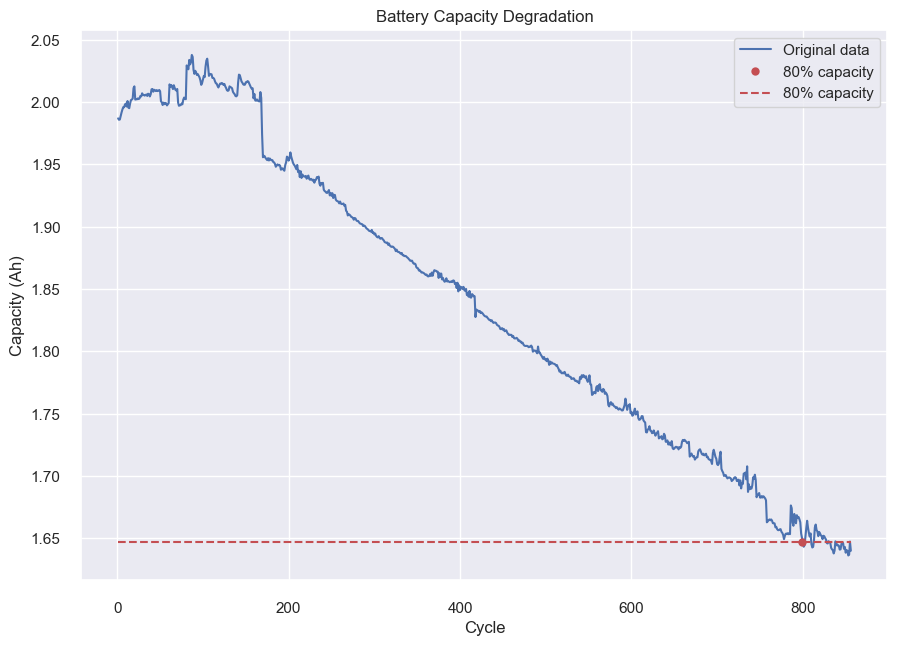

In [10]:
plot_raw(true_capacity1)

模型评估


In [12]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def fit_partial(y, l, r, order):
    y = y[l:r]
    x = np.arange(l, r)
    coef = np.polyfit(x, y, order)
    poly = Polynomial(coef[::-1])
    return poly

def pred_80pct_cycle(poly, initial_capacity):
    coef = poly.coef
    beta_0, beta_1 = coef
    # print(f'intial capacity: {initial_capacity}')
    # print(f'β₀: {beta_0}, β₁: {beta_1}')
    # print(f'80% capacity cycle: {(THRESHOLD * initial_capacity - beta_0) / beta_1}')
    return (THRESHOLD * initial_capacity - beta_0) / beta_1, THRESHOLD * initial_capacity

In [31]:
def plot_poly_pred(poly, x, y, cycle_l, cycle_r):
    plt.figure(figsize=(8, 5))
    y_fit = poly(x)
    plt.plot(x, y, 'bo', label='Original data', markersize=2)
    plt.plot(x, y_fit, 'g-', label='Fitted Curve')
    plt.plot(*get_80pct_cycle(y), 'bo', label='80% Capacity')
    plt.plot(*pred_80pct_cycle(poly, y[0]), 'go', label='Predicted 80% Capacity')
    
    plt.plot([cycle_l, cycle_l], [y[cycle_l]-.1, y[cycle_l]+.1], 'g--', label='Window Range')
    plt.plot([cycle_r, cycle_r], [y[cycle_r]-.1, y[cycle_r]+.1], 'g--')
    
    plt.title('Battery Capacity Degradation', fontsize=18)
    plt.xlabel('Cycle', fontsize=16)
    plt.ylabel('Capacity (mAh)', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [35]:
def plot_iteration_withTrueCapacity(capacity):
    l = 400
    r = 500
    ORDER = 1
    delta_l = 20
    
    cycle = np.arange(1, len(capacity) + 1)
    while r < len(capacity):
        poly = fit_partial(capacity, l, r, ORDER)
        print(f'Partial fit with ({l}, {r})')
        cycle_true, capa_true = get_80pct_cycle(capacity)
        cycle_pred, capa_pred = pred_80pct_cycle(poly, capacity[0])
        print(f'80% capacity: true: {cycle_true}, pred: {cycle_pred:.2f}')
        print(f"error: {abs(cycle_true-cycle_pred):.2f} cycle, relative error: {abs(cycle_true-cycle_pred)/cycle_true:.2%}")
        plot_poly_pred(poly, cycle, capacity, l, r)
        l += delta_l
        r += delta_l

Partial fit with (400, 500)
80% capacity: true: 799, pred: 754.11
error: 44.89 cycle, relative error: 5.62%


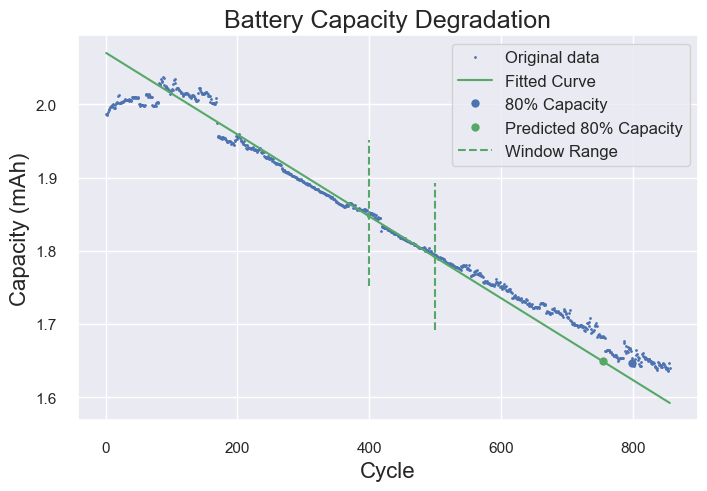

Partial fit with (420, 520)
80% capacity: true: 799, pred: 796.04
error: 2.96 cycle, relative error: 0.37%


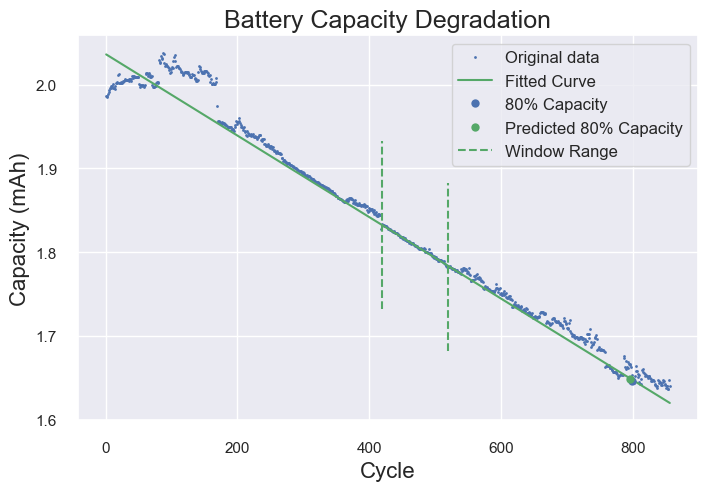

Partial fit with (440, 540)
80% capacity: true: 799, pred: 797.73
error: 1.27 cycle, relative error: 0.16%


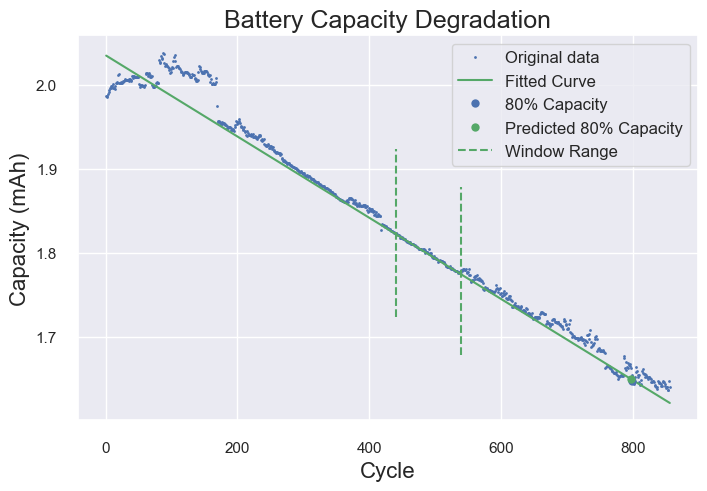

Partial fit with (460, 560)
80% capacity: true: 799, pred: 830.04
error: 31.04 cycle, relative error: 3.88%


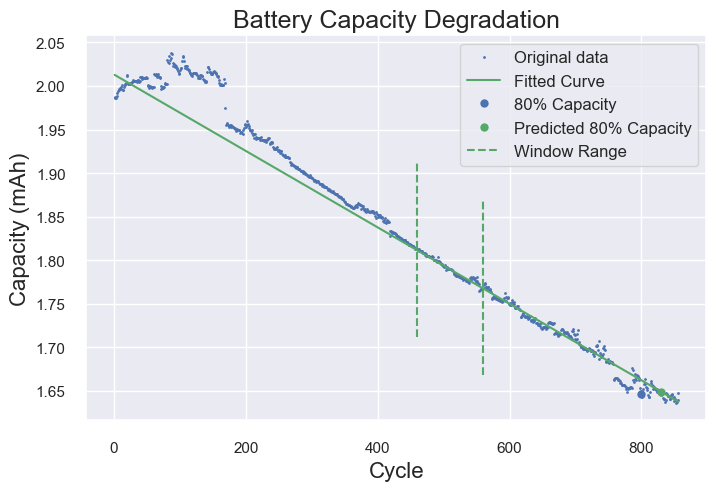

Partial fit with (480, 580)
80% capacity: true: 799, pred: 835.95
error: 36.95 cycle, relative error: 4.62%


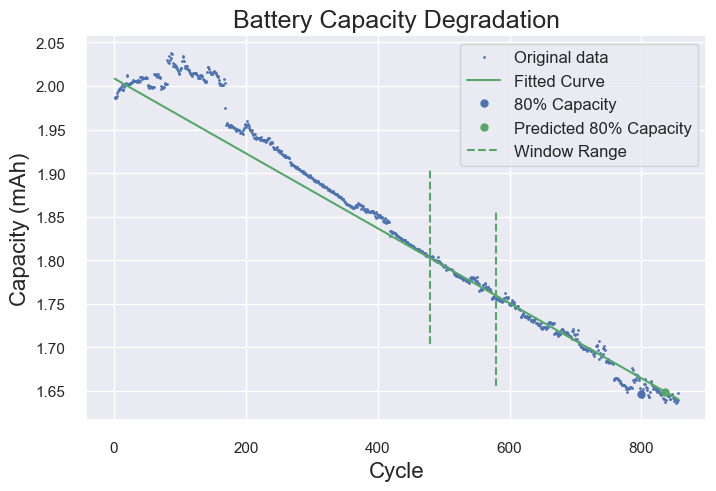

Partial fit with (500, 600)
80% capacity: true: 799, pred: 845.62
error: 46.62 cycle, relative error: 5.83%


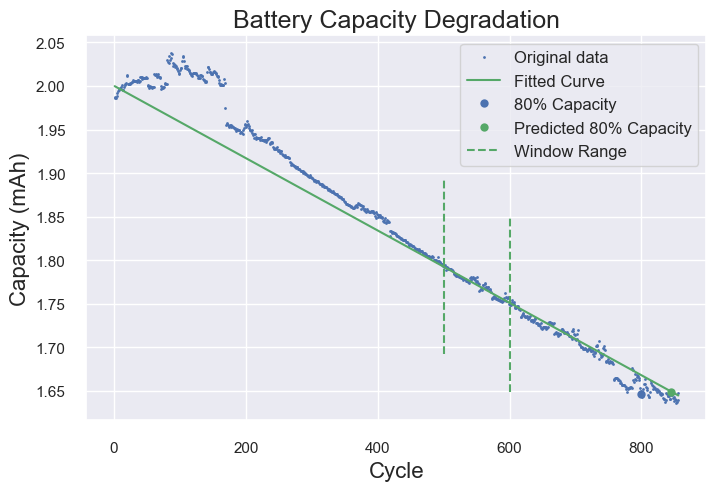

Partial fit with (520, 620)
80% capacity: true: 799, pred: 831.00
error: 32.00 cycle, relative error: 4.01%


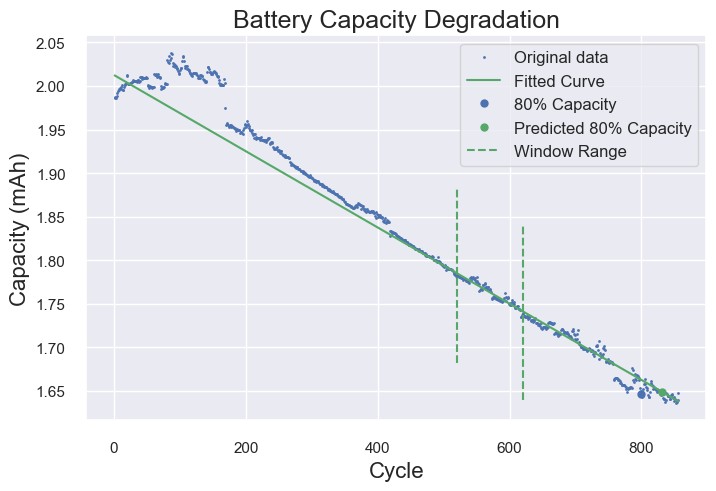

Partial fit with (540, 640)
80% capacity: true: 799, pred: 797.30
error: 1.70 cycle, relative error: 0.21%


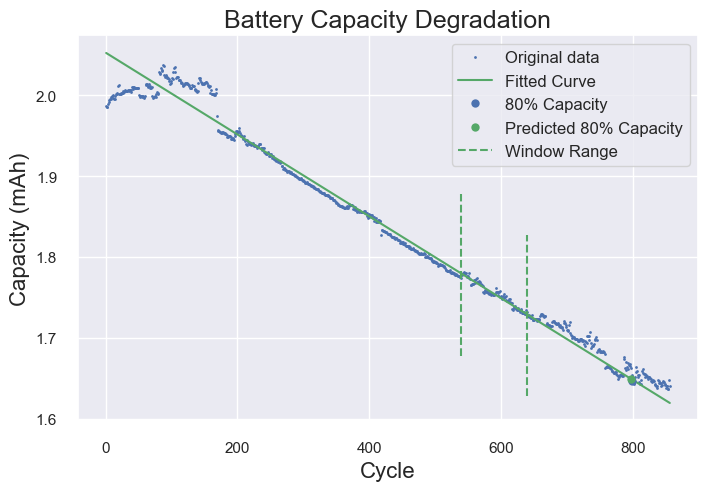

Partial fit with (560, 660)
80% capacity: true: 799, pred: 800.44
error: 1.44 cycle, relative error: 0.18%


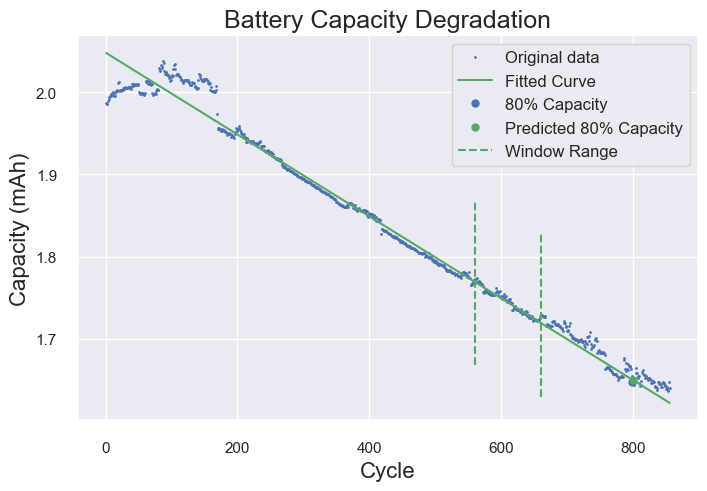

Partial fit with (580, 680)
80% capacity: true: 799, pred: 824.26
error: 25.26 cycle, relative error: 3.16%


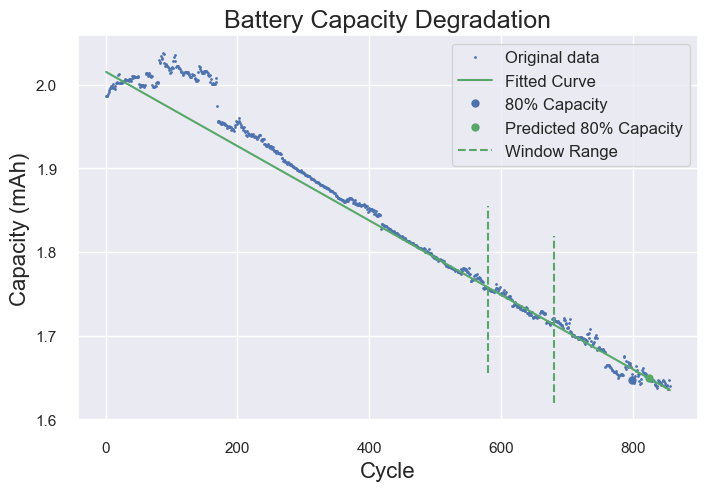

Partial fit with (600, 700)
80% capacity: true: 799, pred: 864.54
error: 65.54 cycle, relative error: 8.20%


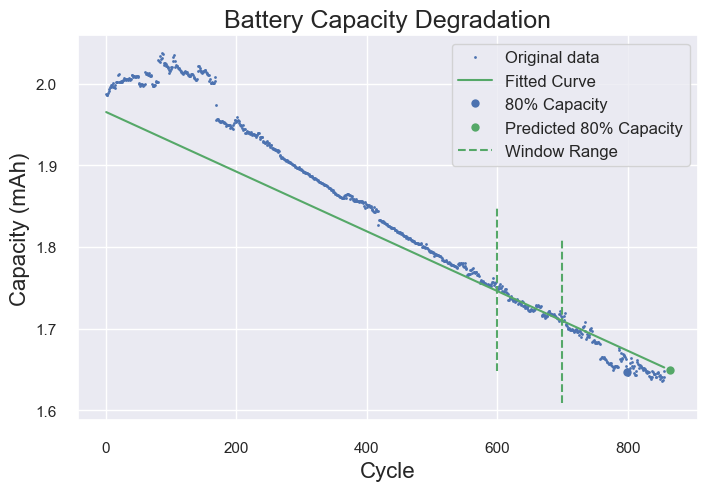

Partial fit with (620, 720)
80% capacity: true: 799, pred: 864.83
error: 65.83 cycle, relative error: 8.24%


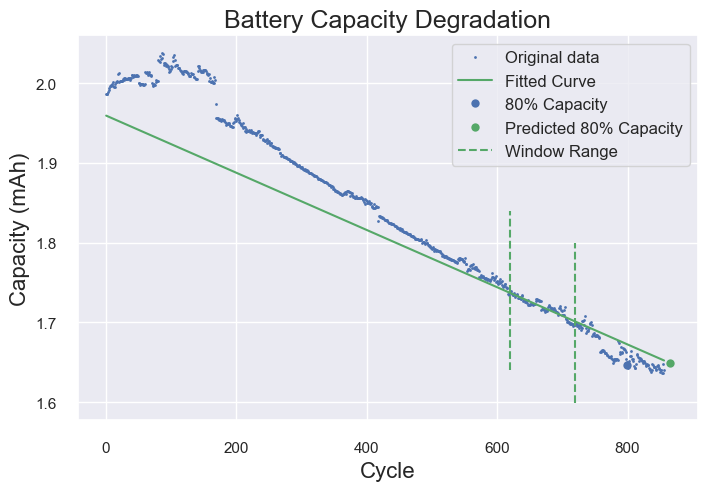

Partial fit with (640, 740)
80% capacity: true: 799, pred: 854.11
error: 55.11 cycle, relative error: 6.90%


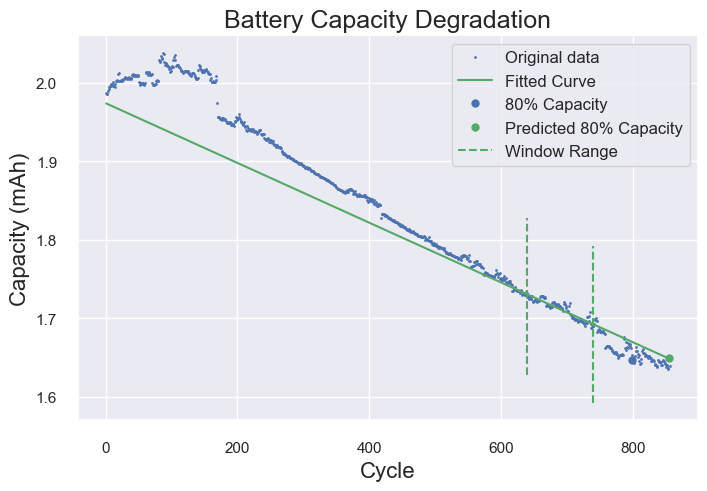

Partial fit with (660, 760)
80% capacity: true: 799, pred: 824.09
error: 25.09 cycle, relative error: 3.14%


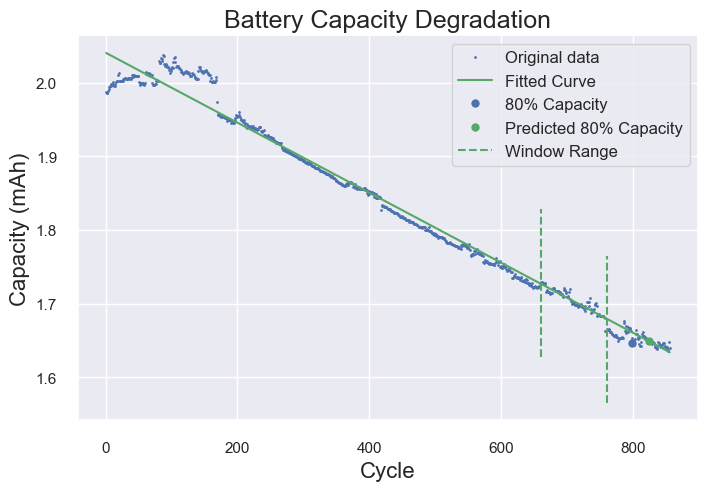

Partial fit with (680, 780)
80% capacity: true: 799, pred: 792.39
error: 6.61 cycle, relative error: 0.83%


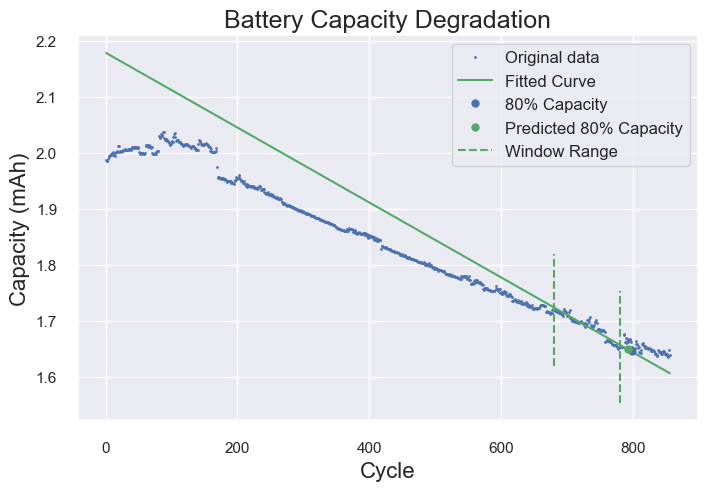

Partial fit with (700, 800)
80% capacity: true: 799, pred: 800.76
error: 1.76 cycle, relative error: 0.22%


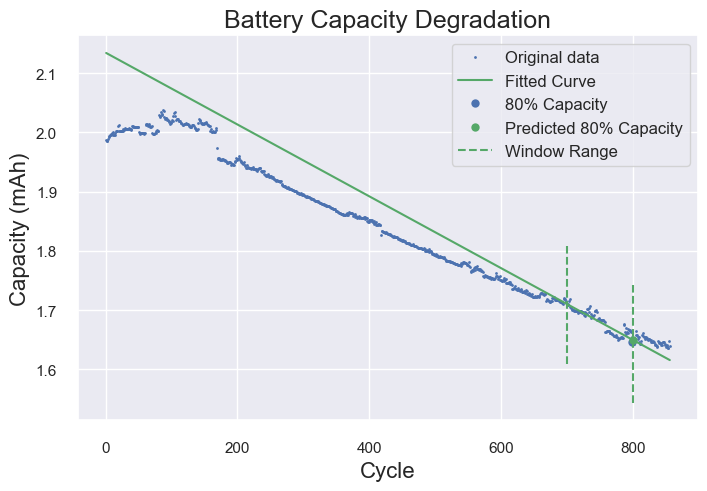

Partial fit with (720, 820)
80% capacity: true: 799, pred: 808.32
error: 9.32 cycle, relative error: 1.17%


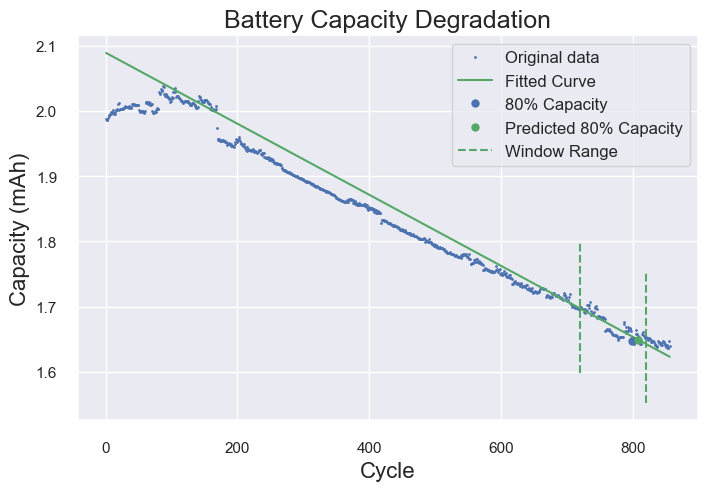

Partial fit with (740, 840)
80% capacity: true: 799, pred: 817.09
error: 18.09 cycle, relative error: 2.26%


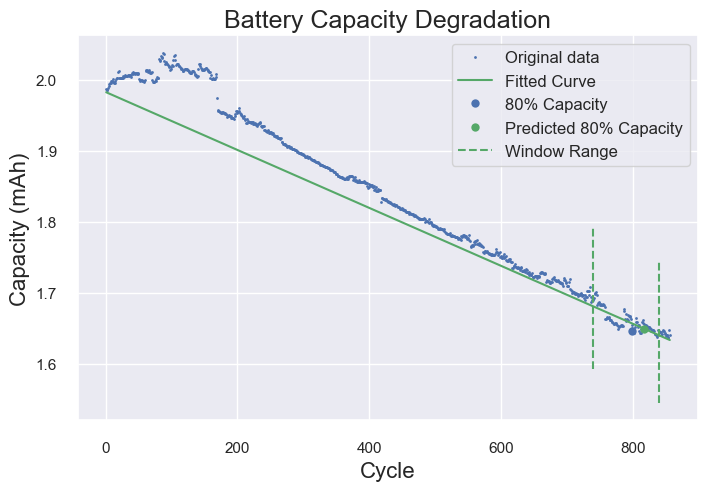

In [36]:
plot_iteration_withTrueCapacity(true_capacity1)

Partial fit with (400, 500)
80% capacity: true: 842, pred: 790.88
error: 51.12 cycle, relative error: 6.07%


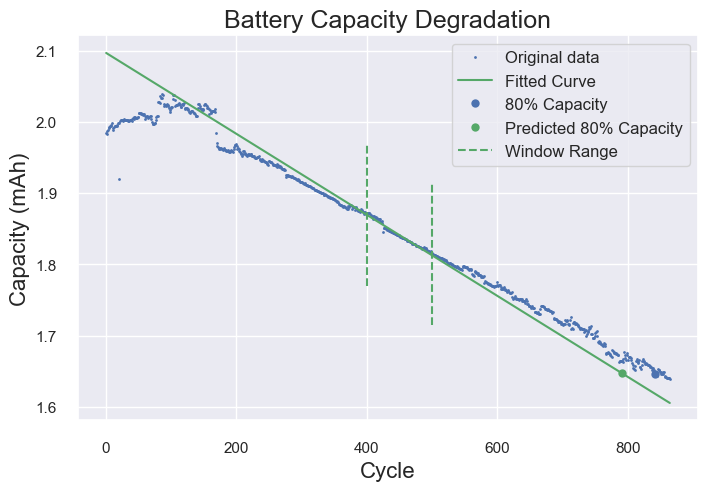

Partial fit with (420, 520)
80% capacity: true: 842, pred: 834.30
error: 7.70 cycle, relative error: 0.92%


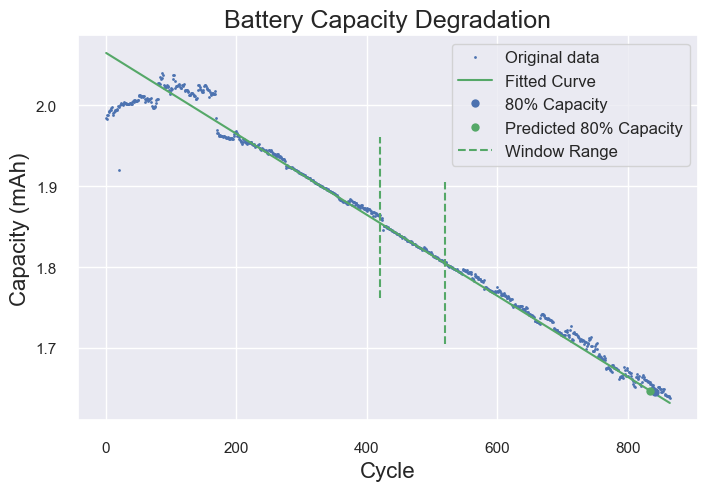

Partial fit with (440, 540)
80% capacity: true: 842, pred: 840.96
error: 1.04 cycle, relative error: 0.12%


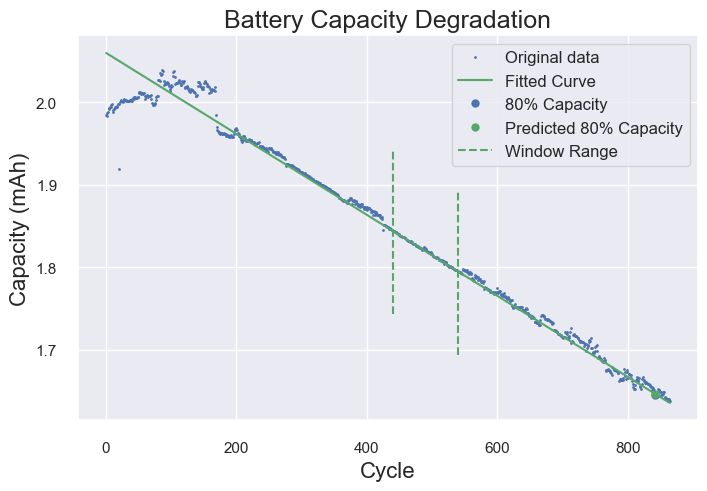

Partial fit with (460, 560)
80% capacity: true: 842, pred: 875.08
error: 33.08 cycle, relative error: 3.93%


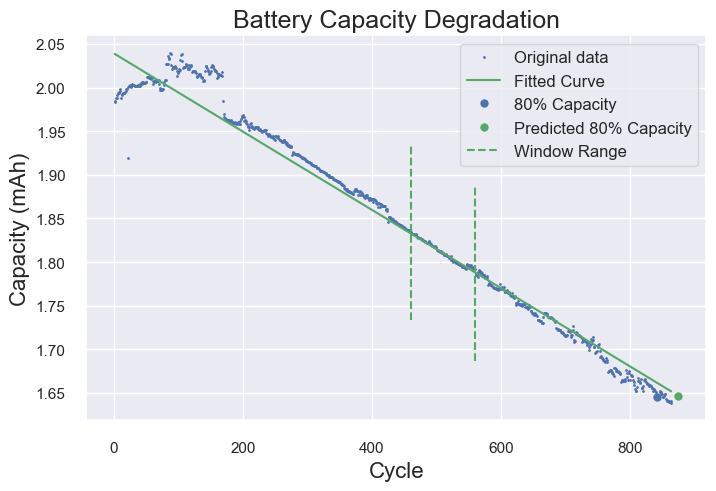

Partial fit with (480, 580)
80% capacity: true: 842, pred: 891.30
error: 49.30 cycle, relative error: 5.86%


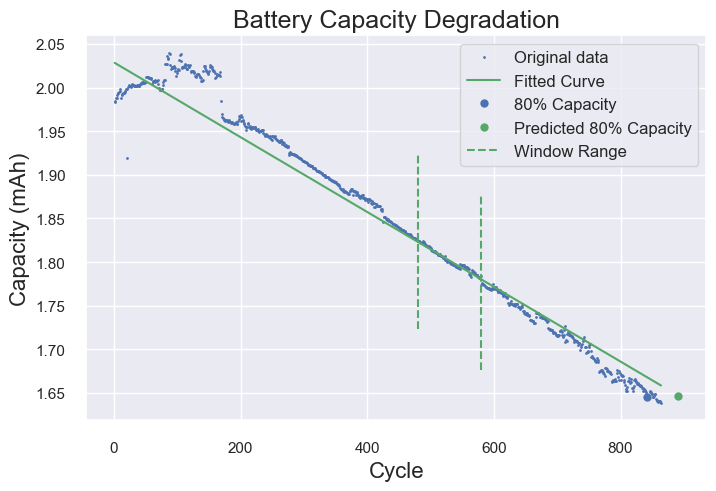

Partial fit with (500, 600)
80% capacity: true: 842, pred: 871.29
error: 29.29 cycle, relative error: 3.48%


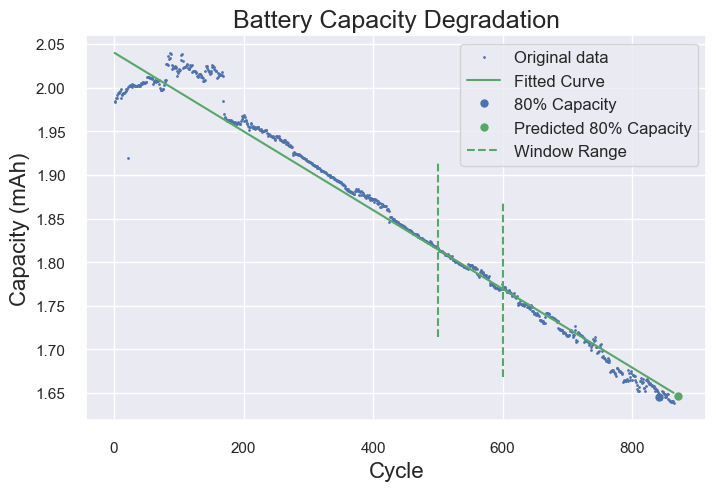

Partial fit with (520, 620)
80% capacity: true: 842, pred: 869.38
error: 27.38 cycle, relative error: 3.25%


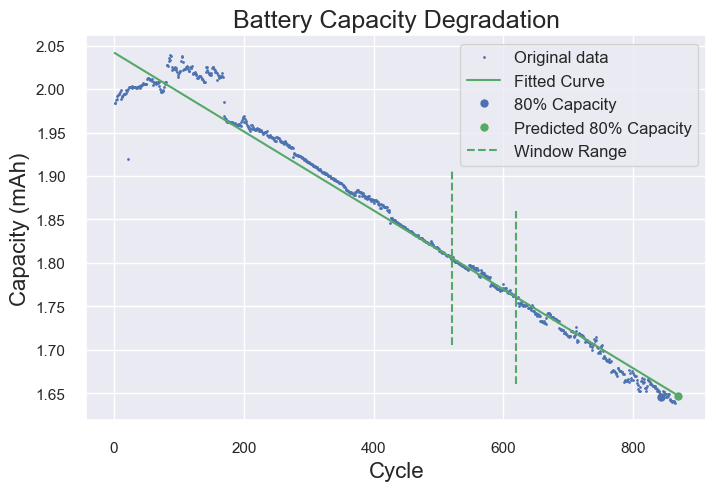

Partial fit with (540, 640)
80% capacity: true: 842, pred: 836.42
error: 5.58 cycle, relative error: 0.66%


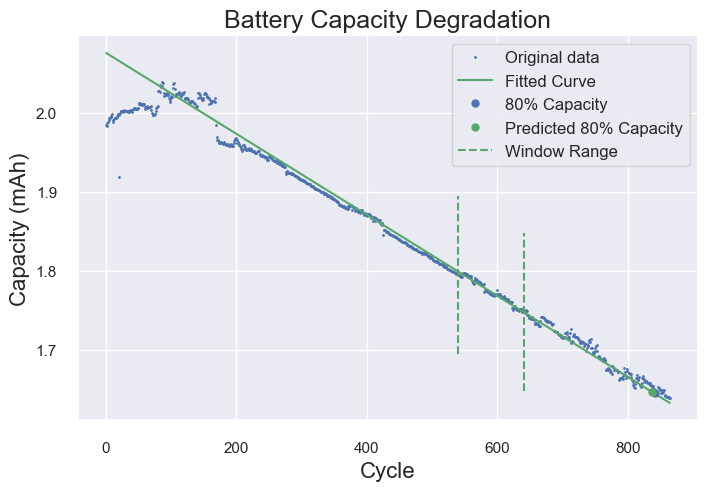

Partial fit with (560, 660)
80% capacity: true: 842, pred: 827.21
error: 14.79 cycle, relative error: 1.76%


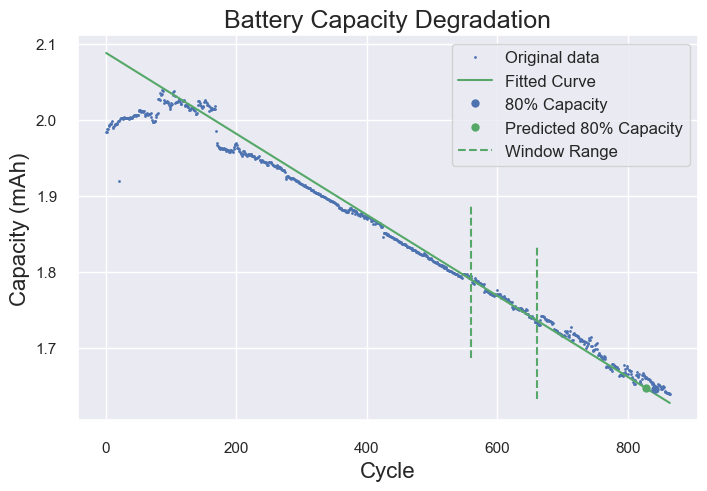

Partial fit with (580, 680)
80% capacity: true: 842, pred: 857.21
error: 15.21 cycle, relative error: 1.81%


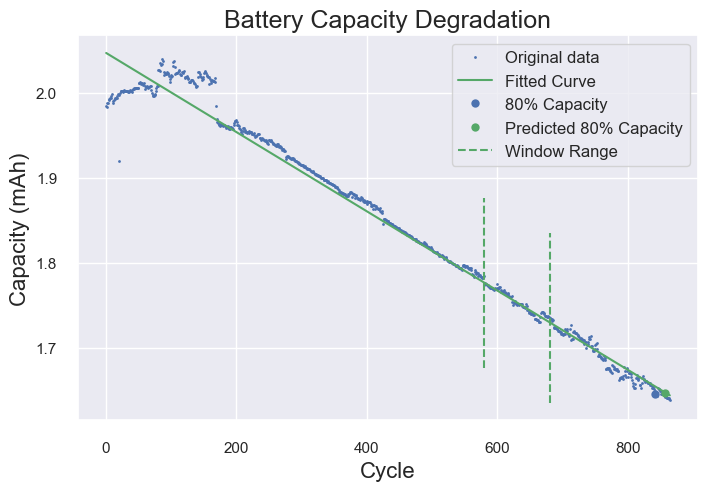

Partial fit with (600, 700)
80% capacity: true: 842, pred: 844.00
error: 2.00 cycle, relative error: 0.24%


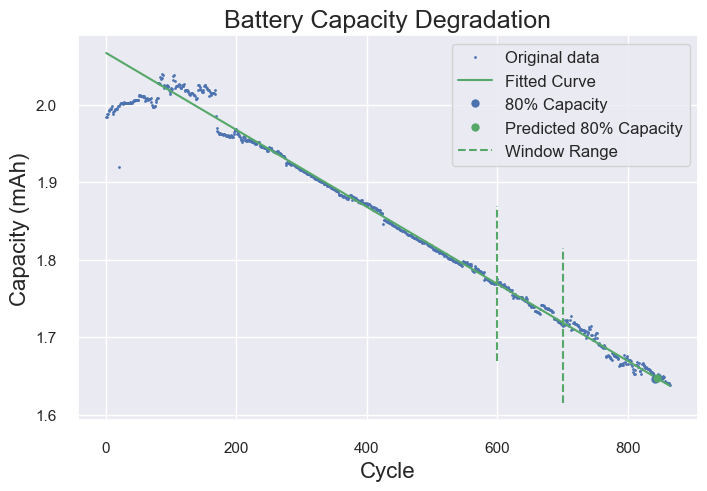

Partial fit with (620, 720)
80% capacity: true: 842, pred: 868.31
error: 26.31 cycle, relative error: 3.12%


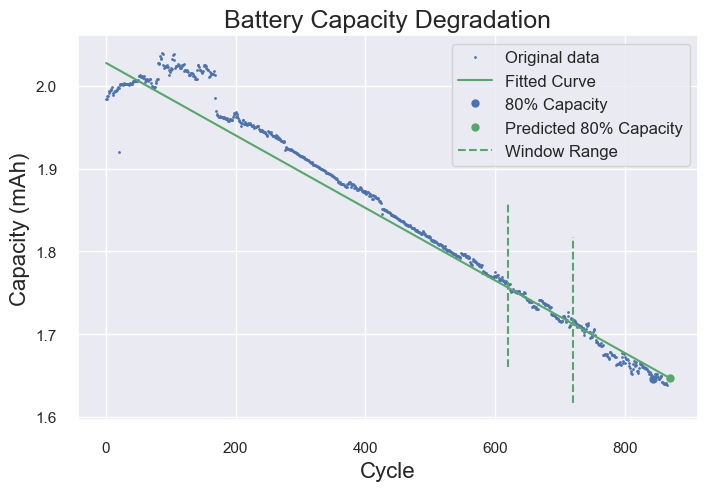

Partial fit with (640, 740)
80% capacity: true: 842, pred: 877.10
error: 35.10 cycle, relative error: 4.17%


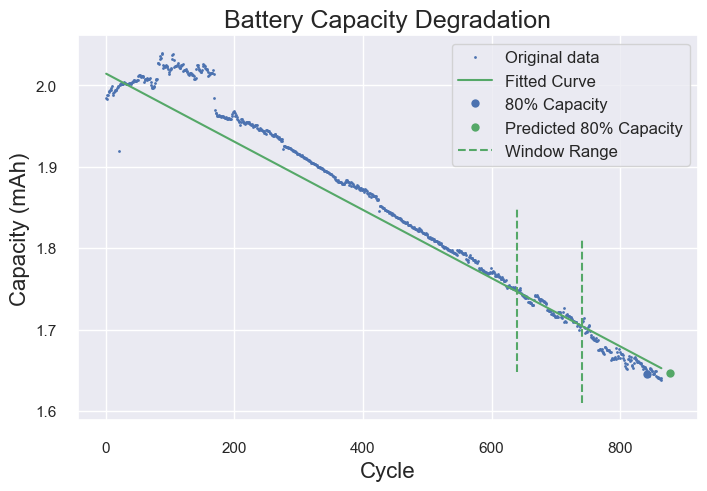

Partial fit with (660, 760)
80% capacity: true: 842, pred: 862.73
error: 20.73 cycle, relative error: 2.46%


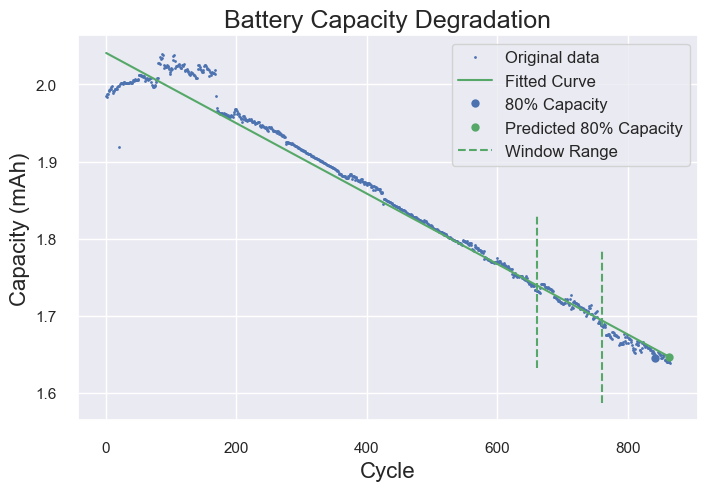

Partial fit with (680, 780)
80% capacity: true: 842, pred: 834.36
error: 7.64 cycle, relative error: 0.91%


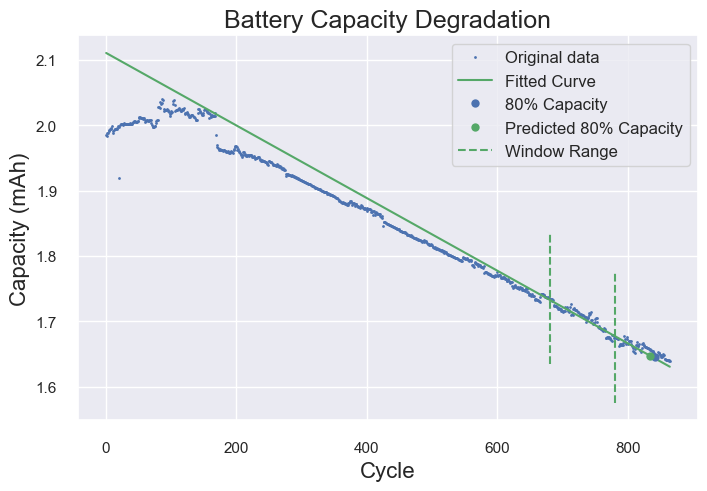

Partial fit with (700, 800)
80% capacity: true: 842, pred: 824.05
error: 17.95 cycle, relative error: 2.13%


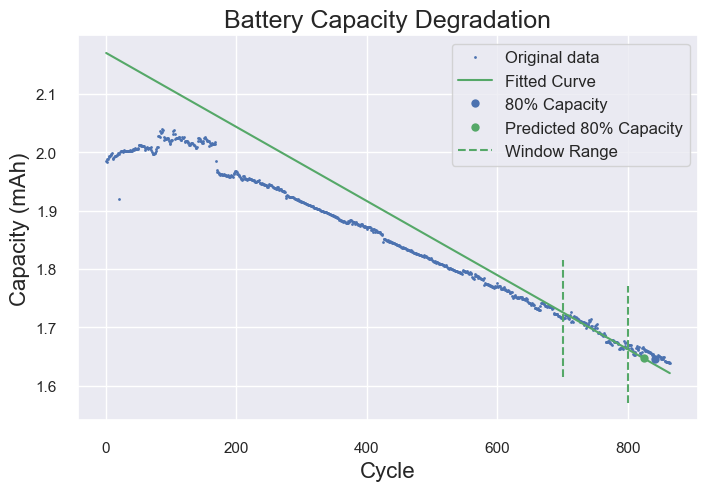

Partial fit with (720, 820)
80% capacity: true: 842, pred: 827.75
error: 14.25 cycle, relative error: 1.69%


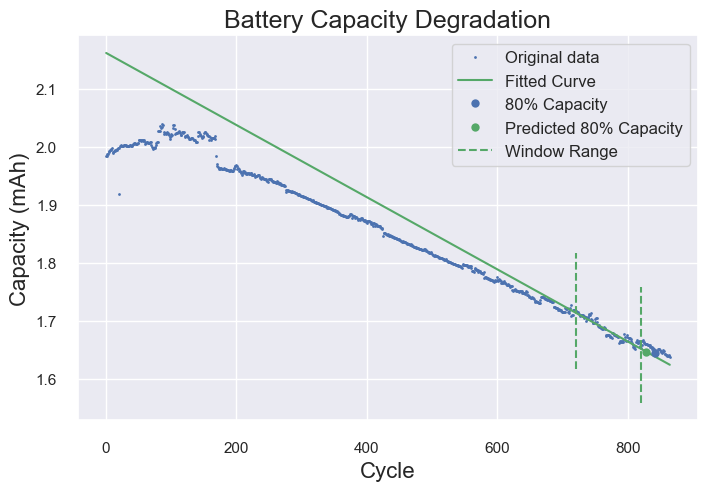

Partial fit with (740, 840)
80% capacity: true: 842, pred: 842.91
error: 0.91 cycle, relative error: 0.11%


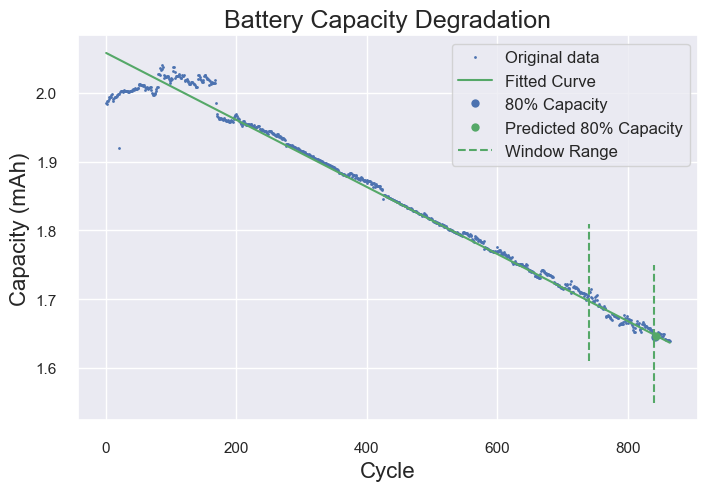

Partial fit with (760, 860)
80% capacity: true: 842, pred: 851.36
error: 9.36 cycle, relative error: 1.11%


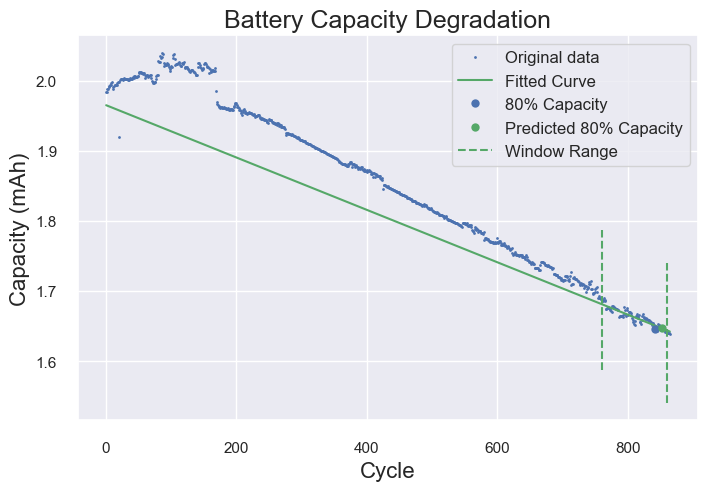

In [37]:
plot_iteration_withTrueCapacity(true_capacity2)

Partial fit with (400, 500)
80% capacity: true: 824, pred: 866.18
error: 42.18 cycle, relative error: 5.12%


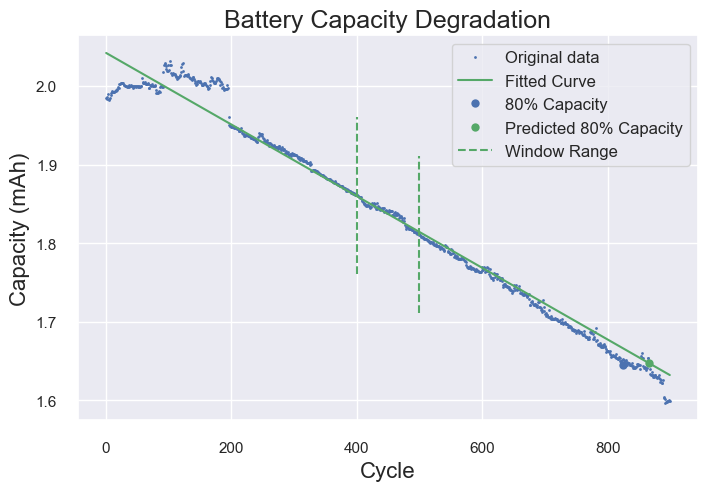

Partial fit with (420, 520)
80% capacity: true: 824, pred: 805.08
error: 18.92 cycle, relative error: 2.30%


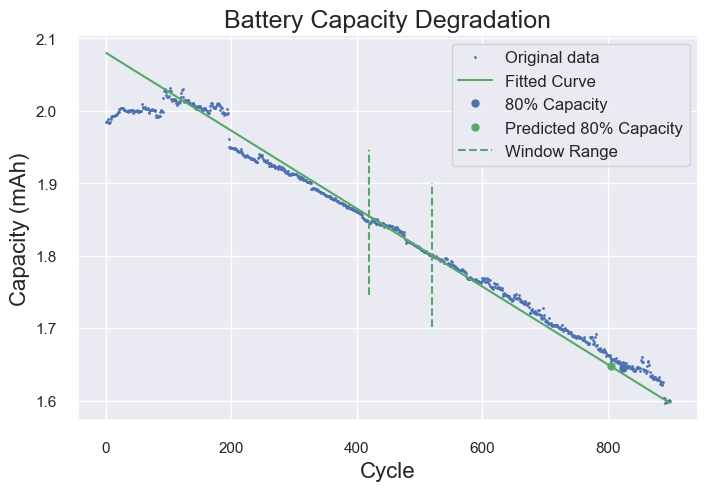

Partial fit with (440, 540)
80% capacity: true: 824, pred: 784.77
error: 39.23 cycle, relative error: 4.76%


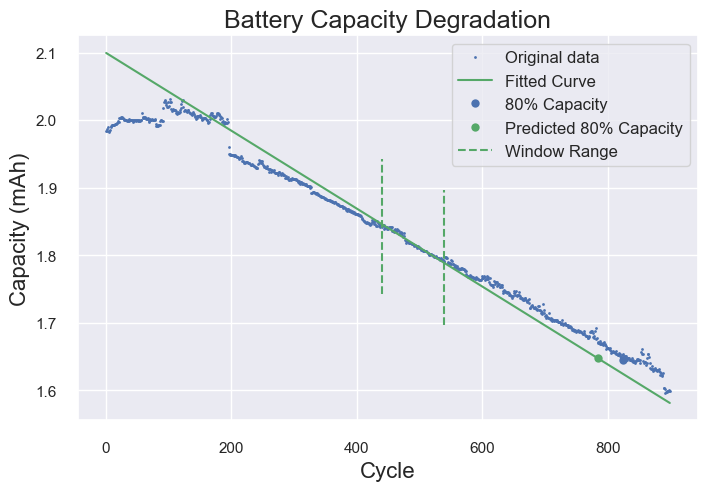

Partial fit with (460, 560)
80% capacity: true: 824, pred: 810.89
error: 13.11 cycle, relative error: 1.59%


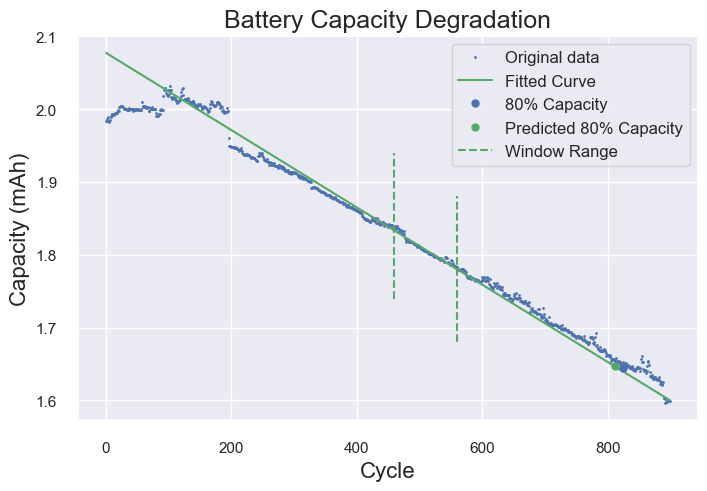

Partial fit with (480, 580)
80% capacity: true: 824, pred: 841.11
error: 17.11 cycle, relative error: 2.08%


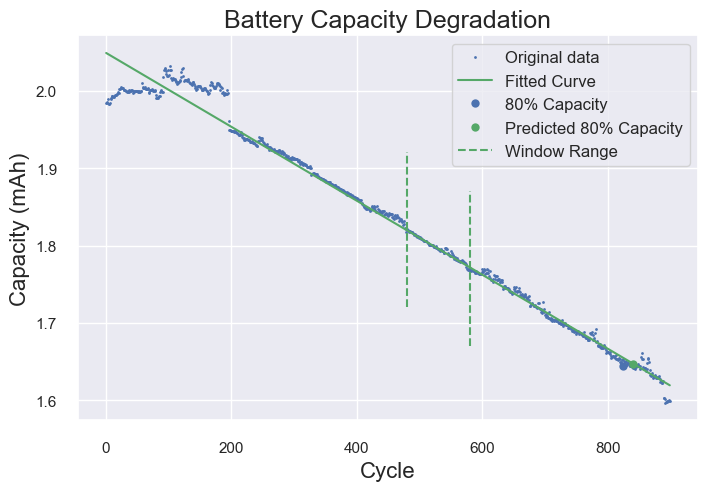

Partial fit with (500, 600)
80% capacity: true: 824, pred: 835.58
error: 11.58 cycle, relative error: 1.41%


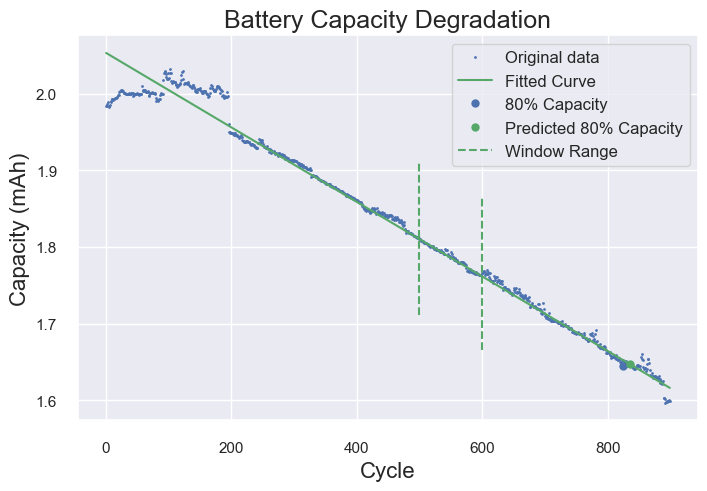

Partial fit with (520, 620)
80% capacity: true: 824, pred: 859.55
error: 35.55 cycle, relative error: 4.31%


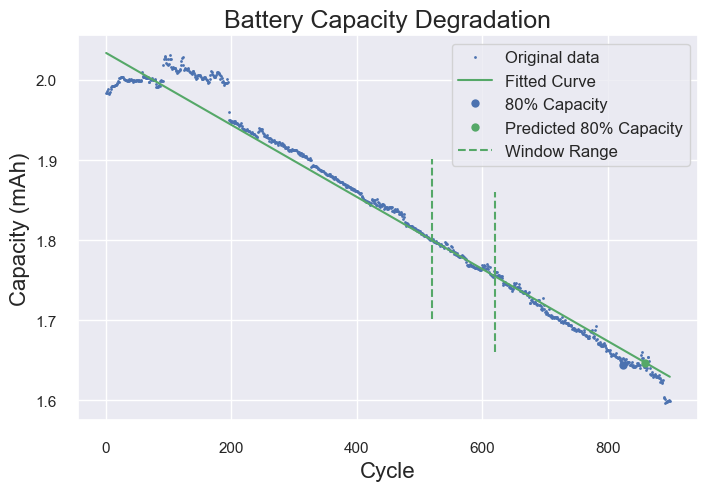

Partial fit with (540, 640)
80% capacity: true: 824, pred: 864.35
error: 40.35 cycle, relative error: 4.90%


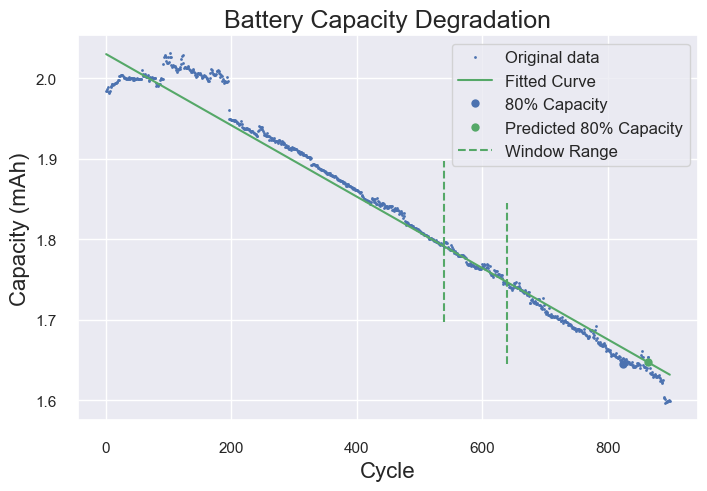

Partial fit with (560, 660)
80% capacity: true: 824, pred: 879.87
error: 55.87 cycle, relative error: 6.78%


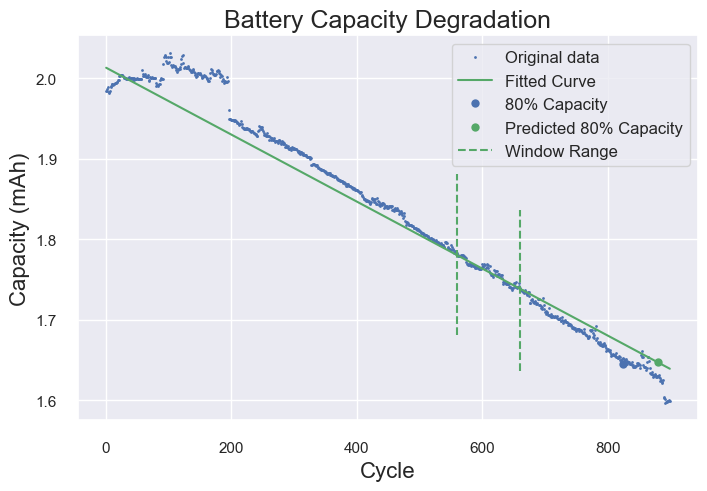

Partial fit with (580, 680)
80% capacity: true: 824, pred: 861.51
error: 37.51 cycle, relative error: 4.55%


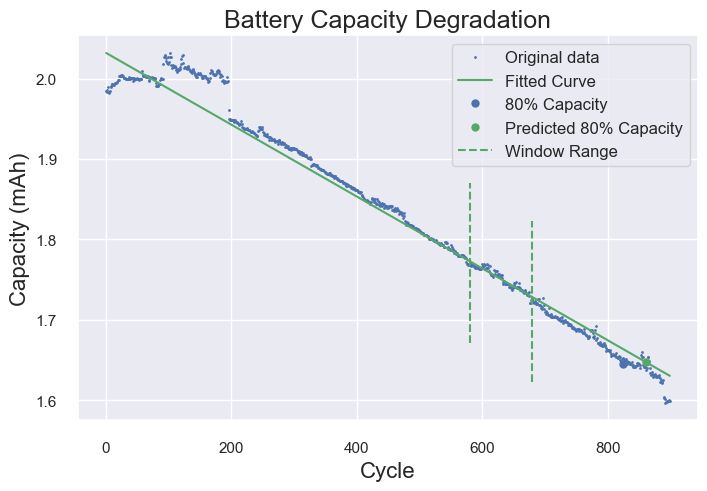

Partial fit with (600, 700)
80% capacity: true: 824, pred: 827.45
error: 3.45 cycle, relative error: 0.42%


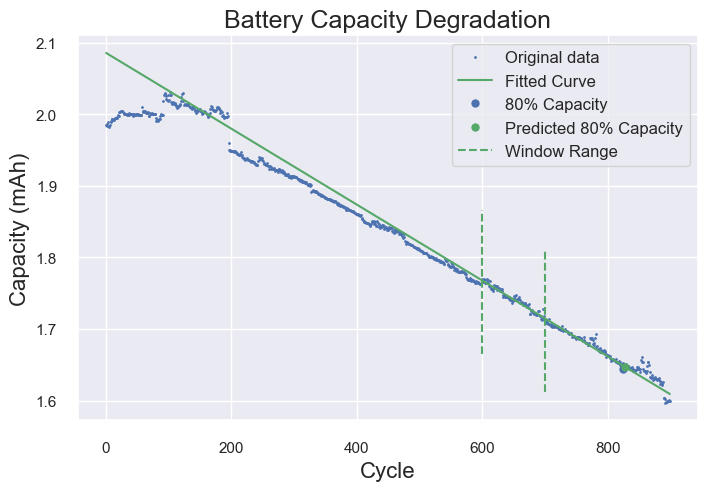

Partial fit with (620, 720)
80% capacity: true: 824, pred: 814.74
error: 9.26 cycle, relative error: 1.12%


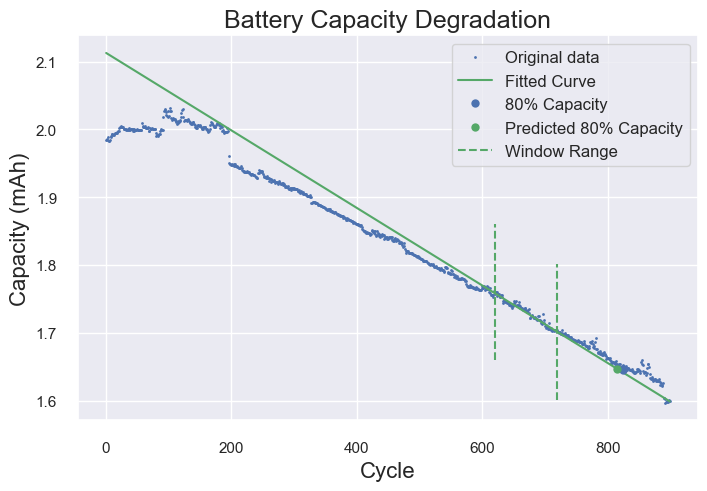

Partial fit with (640, 740)
80% capacity: true: 824, pred: 818.00
error: 6.00 cycle, relative error: 0.73%


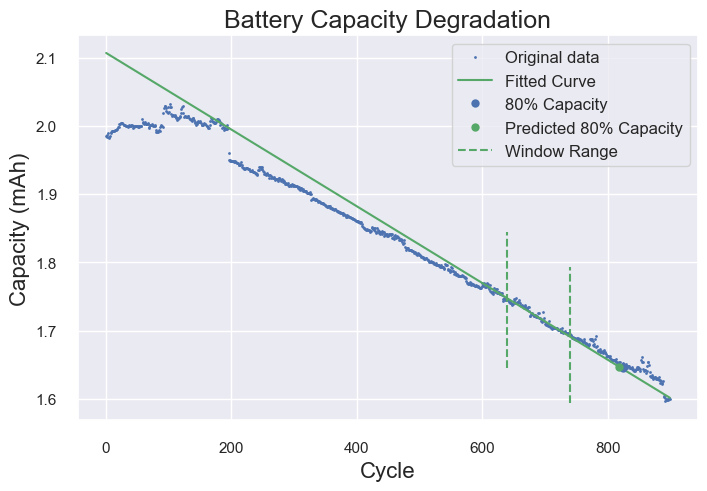

Partial fit with (660, 760)
80% capacity: true: 824, pred: 823.53
error: 0.47 cycle, relative error: 0.06%


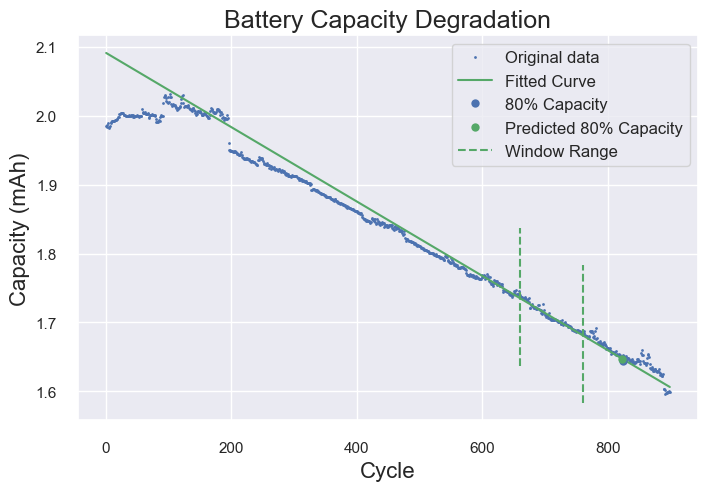

Partial fit with (680, 780)
80% capacity: true: 824, pred: 843.80
error: 19.80 cycle, relative error: 2.40%


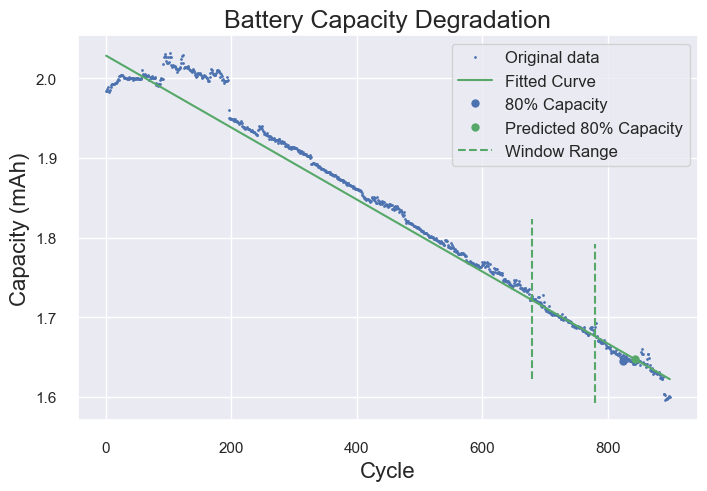

Partial fit with (700, 800)
80% capacity: true: 824, pred: 845.82
error: 21.82 cycle, relative error: 2.65%


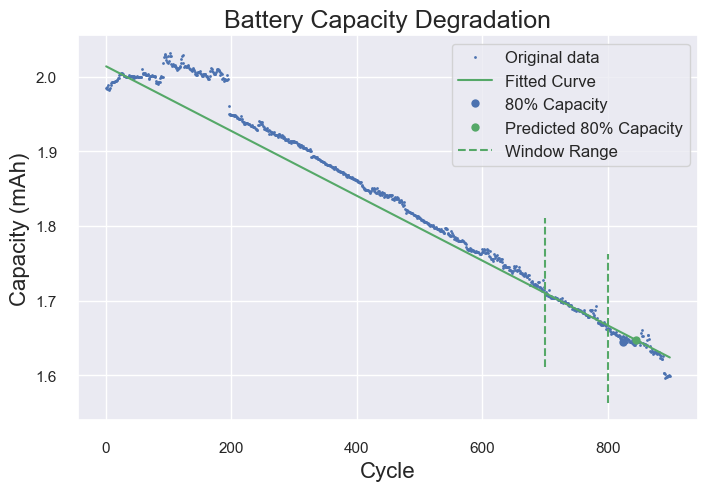

Partial fit with (720, 820)
80% capacity: true: 824, pred: 832.82
error: 8.82 cycle, relative error: 1.07%


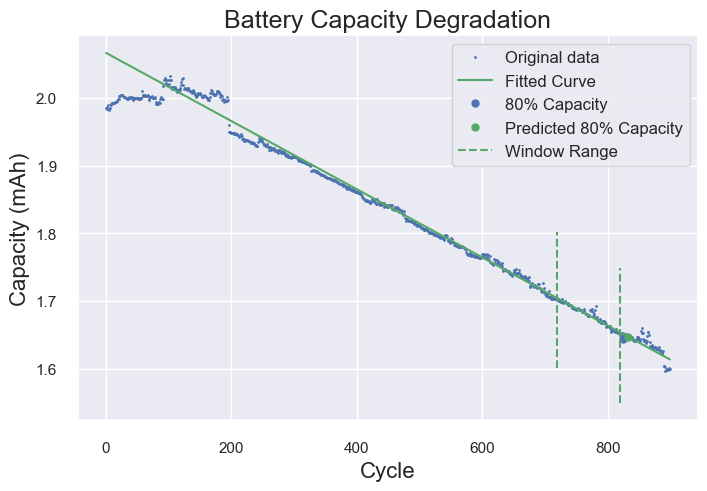

Partial fit with (740, 840)
80% capacity: true: 824, pred: 830.43
error: 6.43 cycle, relative error: 0.78%


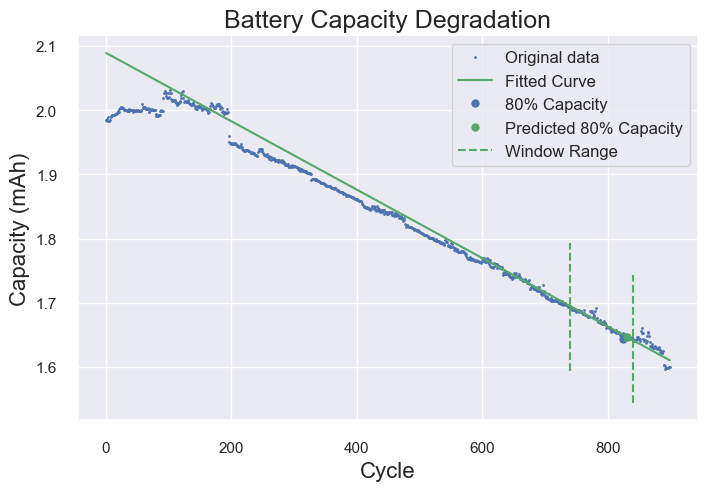

Partial fit with (760, 860)
80% capacity: true: 824, pred: 837.64
error: 13.64 cycle, relative error: 1.65%


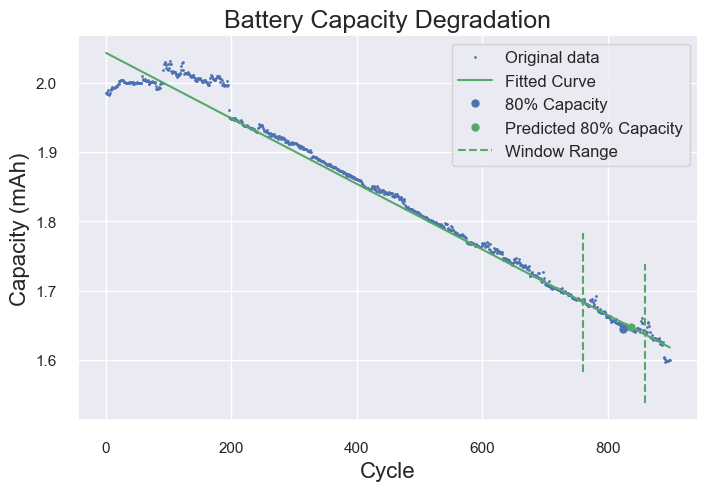

Partial fit with (780, 880)
80% capacity: true: 824, pred: 839.90
error: 15.90 cycle, relative error: 1.93%


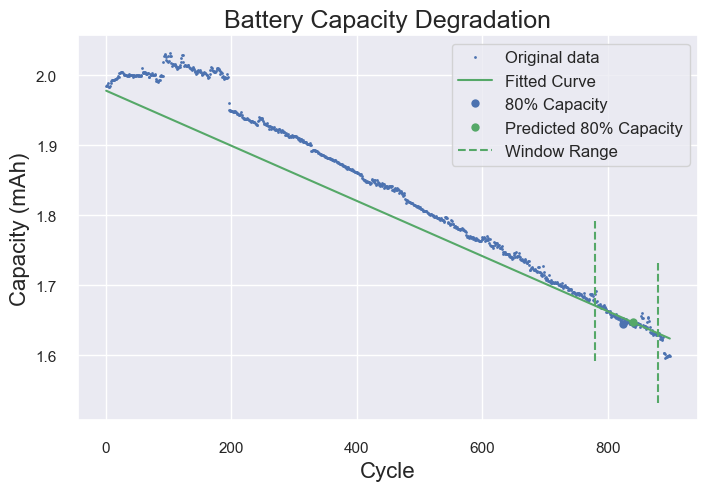

In [38]:
plot_iteration_withTrueCapacity(true_capacity3)

神经网络模型

In [42]:
import torch
from torch import nn

class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)  # 假设输入特征只有1维
        self.fc = nn.Linear(64, 1)  # 假设我们做的是回归任务
    
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (h_n, _) = self.lstm(x)
        x = h_n[-1, :, :]
        return self.fc(x)


In [43]:
from torch import optim

L = 0
R = 800

model = LSTMNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 假设你已经有了训练数据X_train和y_train
# 注意：在训练之前，你需要将数据转换为Tensor

X_train = torch.tensor(cycle[L:R]).float().unsqueeze(-1).unsqueeze(-1)  # 增加两个维度
# 现在X_train的形状应该是 [batch_size, seq_len, features]，其中seq_len=1, features=1
y_train = torch.tensor(capacity[L:R]).float().unsqueeze(-1)  # 确保y_train也有正确的维度


# 训练模型（示例）
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

NameError: name 'cycle' is not defined

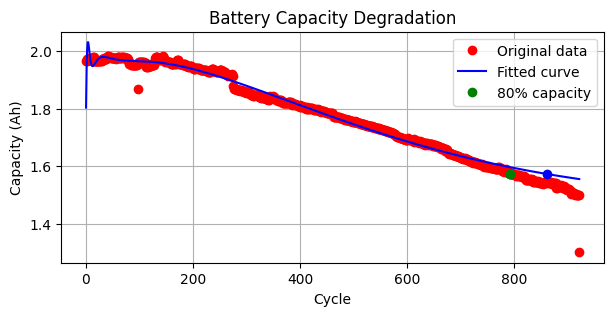

80% capacity cycle: 861, true: 791, diff: 70


In [39]:
y_pred = model(torch.tensor(cycle).float().unsqueeze(-1).unsqueeze(-1)).detach().numpy().flatten()
plt.figure(figsize=(7, 3))
plt.plot(cycle, capacity, 'ro', label='Original data')
plt.plot(cycle, y_pred, 'b-', label='Fitted curve')
plt.plot(*get_80pct_cycle(capacity), 'go', label='80% capacity')
for y in y_pred:
    if y < THRESHOLD * capacity[0]:
        plt.plot(cycle[y_pred == y], y_pred[y_pred == y], 'bo')
        target_cycle = cycle[y_pred == y][0]
        break
# plt.plot(*pred_80pct_cycle(poly, y[0]), 'bo', label='Predicted 80% capacity')
plt.title('Battery Capacity Degradation')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.show()

print(f'80% capacity cycle: {target_cycle}, true: {get_80pct_cycle(capacity)[0]}, diff: {abs(target_cycle-get_80pct_cycle(capacity)[0])}')